In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import os
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [17]:
from IPython.display import display, Image

In [18]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [19]:
ref_folder_path = "ref2"
# images_folder_path = "images"
output_path = 'outputs2'
file_name = "original"
ext = "png"

In [20]:
image_path = os.path.join(ref_folder_path, f"{file_name}.{ext}")

ref_save_folder_path = ref_folder_path
os.makedirs(ref_save_folder_path, exist_ok=True)


In [21]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import cv2

p = []



image = cv2.imread(image_path)
cv2.imwrite(os.path.join(ref_save_folder_path, f"{file_name}.{ext}"), image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


img_trace = px.imshow(image)
img_fig = go.FigureWidget()
img_fig.add_trace(img_trace.data[0])


# img_fig.add_trace(go.Scatter(mode='markers'))
# scatter = img_fig.data[1]
# colors = ['#a3a7e4'] * 100
# scatter.marker.color = colors
# scatter.marker.size = [100] * 100

def on_click_figure(trace, points, state):
    x, y = points.point_inds[0]
    p.append([y,x])
    img_fig.add_trace(go.Scatter(x=[y], y=[x], mode='markers'))
    scatter = img_fig.data[-1]
    # colors = ['#bae2be'] * 100
    # scatter.marker.color = colors
    # scatter.marker.size = [10] * 100

img_fig.data[0].on_click(on_click_figure)

# def update_point(trace, points, selector):
#     points.xs.append(p[0][0])
#     points.ys.append(p[0][1])
#     c = list(scatter.marker.color)
#     s = list(scatter.marker.size)
    
#     for i in points.point_inds:
#         c[i] = '#bae2be'
#         s[i] = 500
#         with img_fig.batch_update():
#             scatter.marker.color = c
#             scatter.marker.size = s

# scatter.on_click(update_point)

display(img_fig)

FigureWidget({
    'data': [{'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: [%{z[0]}, %{z[1]}, %{z[2]}]<extra></extra>',
              'name': '0',
              'source': ('data:image/png;base64,iVBORw0K' ... 'Dk5y0PrDmE8AAAAABJRU5ErkJggg=='),
              'type': 'image',
              'uid': '8264cffc-4d9a-4dd1-8160-af95896e9bbf',
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'template': '...'}
})

In [22]:
print(p)

[[2692, 1324]]


In [23]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../sam/sam_vit_h.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

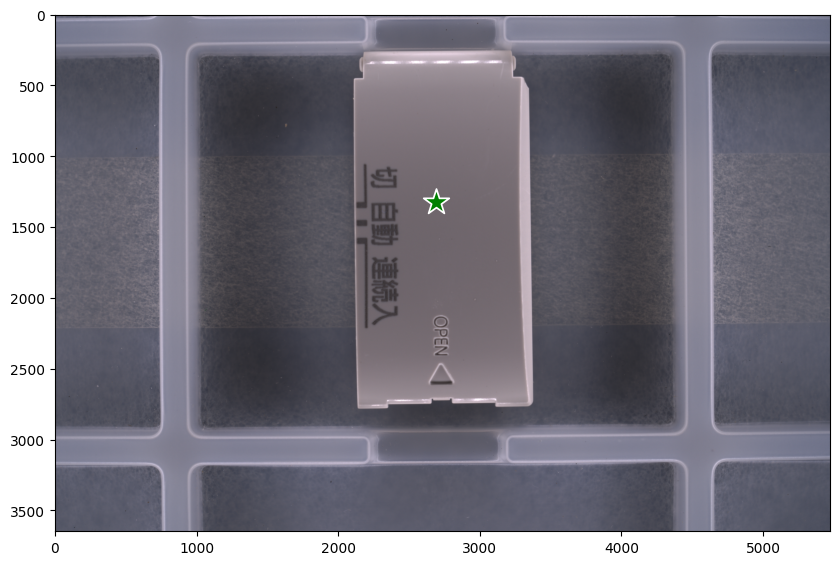

In [24]:
input_point = np.array([p[-1]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

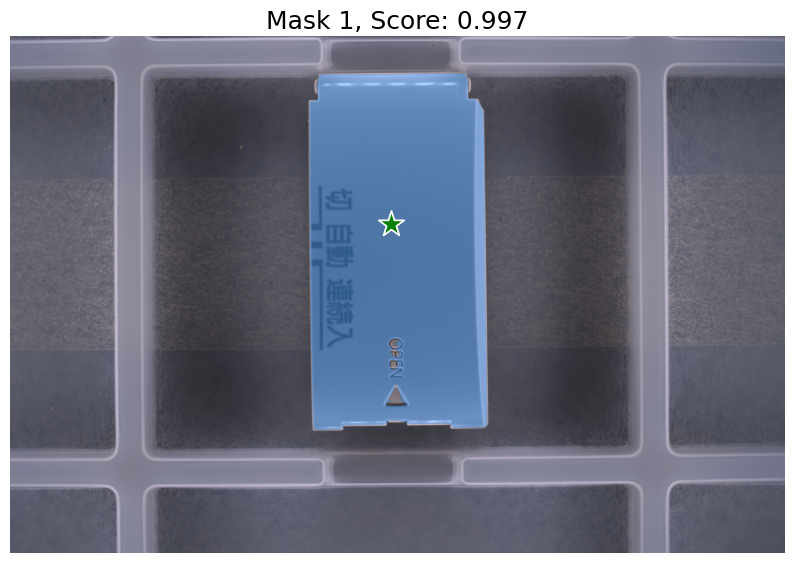

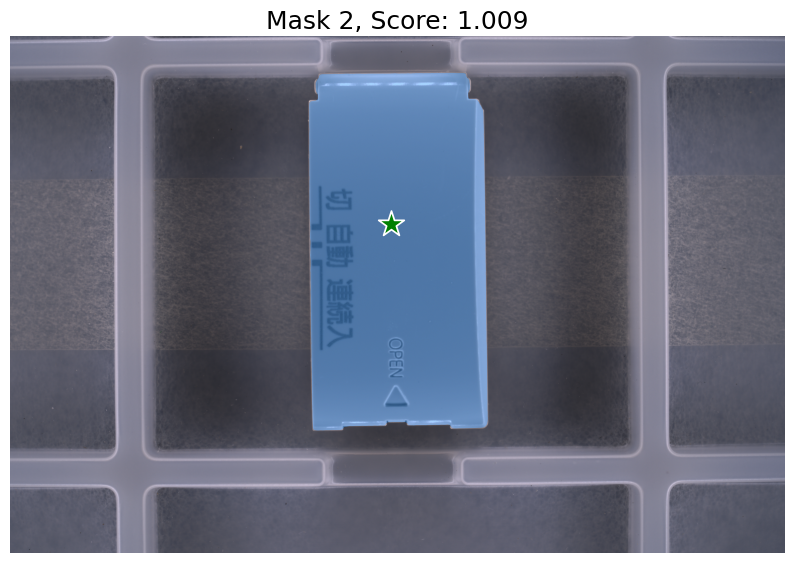

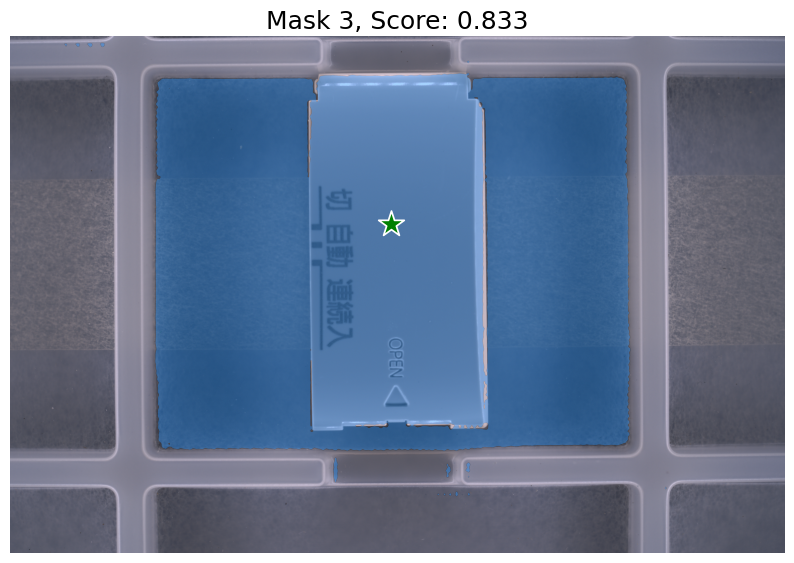

In [25]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [26]:
best_idx = np.argmax(scores)
final_mask = masks[best_idx]
masked_image = np.zeros((final_mask.shape[0], final_mask.shape[1], 3), dtype=np.uint8)
masked_image[final_mask, :] = image[final_mask, :]
cv2.imwrite(os.path.join(ref_folder_path, f"masked_image.{ext}"), cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))

mask_colors = np.zeros((final_mask.shape[0], final_mask.shape[1], 3), dtype=np.uint8)
mask_colors[final_mask, :] = np.array([[0, 0, 128]])
cv2.imwrite(os.path.join(ref_folder_path, f"mask.{ext}"), mask_colors)

True